# Cat breeds model training notebook

Исходные данные размещены на Kaggle (размеченные фотографии 67 пород кошек):
https://www.kaggle.com/ma7555/cat-breeds-dataset

Данные загружаются с Google Drive, для этого необходимо его смонтировать
загрузку файла по прямой ссылке без монтирования не удалось реализовать, т.к.
Google Drive при загрузке большого файла открывает страницу с предупреждением
про проверку антивирусом

для воспроизведения обучения модели необходимо файл с данными Archive.zip
разместить на Google Drive в папке data (или поменять код в следующей ячейке,
если расположение файла другое) 

ВИМАНИЕ! Данный ноутбук запускался на Colab Pro+ в варианте GPU+High RAM (64Gb).

In [ ]:
# создаем диск в оперативной памяти
!mkdir cache
!mount -t tmpfs -o size=10000M tmpfs cache
# !pip install --upgrade torchvision # - если нужно обновить torchvision

In [ ]:
# перед запуском ноутбука нужно установить значение MODE по сценарию, который необходимо запустить
# 101 - генерация фич и предсказаний всех моделей из MODELS_LIST, далее предсказание на их основе с помощью XGBoost
# 110 - генерация фич и предсказаний всех моделей из MODELS_LIST, далее предсказание на их основе с помощью MLP
# 300 - совместная тренирока "с нуля" всех базовых моделей и принимающей решения "головы"
# 301 - тренировка одной модели на выбор

MODE = 301

CLASS_NUM=67
WARM_START=True
TPU=False # использовать ли TPU вместо GPU
BATCH_SIZE=16
MODELS_LIST={
    'efficientnet':'efficientnet_warmstart',
    'resnet':'resnet_warmstart',
    'vgg':'vgg_warmstart',
    'regnet':'regnet_warmstart', 
    'densenet':'densenet_warmstart',
    'resnext':'resnext_warmstart',
    'mnasnet':'mnasnet_warmstart',
    'mobilenet':'mobilenet_warmstart'
}
MODELS_BS_FOR_JOINT={
    'efficientnet':16,
    'mobilenet':64, 
    'densenet':32,
    'resnext':64,
    'resnet':32,
    'vgg':32,
    'mnasnet':32,
    'regnet':16    
}
LIMIT=None #использовать не всю базу, а ограничить этим количеством; None = не ограничивать
TRAIN_SHARE=0.8
VAL_SHARE=0.1
TEST_SHARE=0.1
DATA_FOLDER='/content/cache/'
DATA_FOLDER_PERSISTENT='/content/gdrive/MyDrive/data/'
REGISTRY='model_register.csv' # здесь будут записи о натренированных моделях

In [ ]:
# раcкомментить для использования TPU
  # !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
  # !pip install --upgrade cloud-tpu-client

In [ ]:
# импорт библиотек
from google.colab import drive
import pandas as pd
import os
import glob
from functools import partial
from collections import OrderedDict
from IPython import display

import math
import random
import string

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, Subset, DataLoader

import torchvision as tv

import requests

import io as io_

from skimage import io

import PIL

from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
import pickle

from xgboost.sklearn import XGBClassifier
import time

from tqdm import tqdm
import collections

from matplotlib_venn import venn2

import gc

In [ ]:
# загрузка и распаковка датасета
drive.mount('/content/gdrive')
#!mkdir /content/cats/
!unzip -q /content/gdrive/MyDrive/data/Archive.zip -d /content/cache/

Mounted at /content/gdrive


In [ ]:
# несколько классов и функций для дальнейшей работы

# функця, выдающая класс модели по ее имени
def model_class_by_name (name):
  if name=='mobilenet':
    return tv.models.mobilenet_v3_large
  elif name=='densenet':
    return tv.models.densenet161
  elif name=='efficientnet':
    return tv.models.efficientnet_b6
  elif name=='resnext':
    return tv.models.resnext50_32x4d
  elif name=='resnet':
    return tv.models.resnet152
  elif name=='vgg':
    return tv.models.vgg19_bn
  elif name=='mnasnet':
    return tv.models.mnasnet1_0
  elif name=='regnet':
    return tv.models.regnet_y_32gf
    
  else:
    raise ValueError('Unknown model name')

# функция, создающая модель из предобученной модели, заменяя количество классов,
def create_model (name, classes_num, load_from_disk=False):
  model=model_class_by_name(name)(pretrained=True)
  if load_from_disk:
    if os.path.isfile(DATA_FOLDER_PERSISTENT+name+'_warmstart'):
        model.load_state_dict(torch.load(DATA_FOLDER_PERSISTENT+name+'_warmstart'))
        print ('Loaded '+name+'base model for warm start')  
  if name=='mobilenet':
    model.classifier[3]=nn.Linear(in_features=1280, out_features=classes_num, bias=True)
  elif name=='densenet':
    model.classifier=nn.Linear(in_features=2208, out_features=classes_num, bias=True)
  elif name=='efficientnet':
    model.classifier[1]=nn.Linear(in_features=2304, out_features=classes_num, bias=True)
  elif name=='resnext':
    model.fc=nn.Linear(in_features=2048, out_features=classes_num, bias=True)
  elif name=='resnet':
    model.fc=nn.Linear(in_features=2048, out_features=classes_num, bias=True)
  elif name=='vgg':
    model.classifier[6]=nn.Linear(in_features=4096, out_features=classes_num, bias=True)
  elif name=='mnasnet':
    model.classifier[1]=nn.Linear(in_features=1280, out_features=classes_num, bias=True)
  elif name=='regnet':
    model.fc=nn.Linear(in_features=3712, out_features=classes_num, bias=True)
  else:
    raise ValueError('Unknown model name')

  return model

# класс на основе предтренированной модели создает модель, выдающую не только логиты, но и фичи
class ModelWithFeatures(nn.Module):

  def __init__(self, name, classes_num,load_from_disk=False):
    super(ModelWithFeatures,self).__init__()
    self.name=name
    self.classes_num=classes_num
    self.base_model=create_model(self.name,self.classes_num,load_from_disk=load_from_disk)
    self.activation = {}
    def get_activation(name):
      def hook(model, input, output):
          self.activation[name] = output.detach()
      return hook
    if name=='mobilenet':
      self.base_model.avgpool.register_forward_hook(get_activation('features'))
    elif name=='densenet':
      self.base_model.features.norm5.register_forward_hook(get_activation('features'))
    elif name=='efficientnet':
      self.base_model.avgpool.register_forward_hook(get_activation('features')) 
    elif name=='resnext':
      self.base_model.avgpool.register_forward_hook(get_activation('features'))
    elif name=='resnet':
      self.base_model.avgpool.register_forward_hook(get_activation('features'))
    elif name=='vgg':
      self.base_model.classifier[1].register_forward_hook(get_activation('features'))
    elif name=='mnasnet':
      self.base_model.classifier[0].register_forward_hook(get_activation('features'))
    elif name=='regnet':
      self.base_model.avgpool.register_forward_hook(get_activation('features'))
    else:
      raise ValueError('Unknown model name')
    if self.name in ('regnet','efficientnet','mobilenet','resnext','resnet','densenet'):
      self.squeezer=(lambda x:x[...,0,0])
    else:
      self.squeezer=(lambda x:x)
    test_image=torch.Tensor(np.zeros((1,3,224,224)))
    self.base_model.eval()
    _=self.base_model(test_image)
    self.features_num=self.activation['features'].shape[1] # это измерение показывает количество извлеченных фич
    self.logits_position_in_pool=None
    self.features_position_in_pool=None
  
  def forward (self,x):
    r=self.base_model(x)
    return torch.cat((r,self.squeezer(self.activation['features'])),axis=-1)

# класс, который пеегруппировывает результаты базовых моделей, чтобы сначала шли все логиты, потом все фичи
class RegroupResults(nn.Module):
  def __init__(self, list_of_models):
    super(RegroupResults,self).__init__()
    self.list_of_models=list_of_models
    self.logits_num=0
    self.features_num=0
    for model in list_of_models:
      self.logits_num=self.logits_num+model.classes_num
      self.features_num=self.features_num+model.features_num
    n1=0
    n2=0
    for model in list_of_models:
      model.logits_position_in_pool=n1
      n1=n1+model.classes_num
      model.features_position_in_pool=n2+self.logits_num
      n2=n2+model.features_num
  def forward(self,x):
    n=0
    logits=[]
    features=[]
    for model in self.list_of_models:
      logits.append(x[...,n:n+model.classes_num])
      n=n+model.classes_num
      features.append(x[...,n:n+model.features_num])
      n=n+model.features_num
    return torch.cat((torch.cat(logits, axis=-1),torch.cat(features,axis=-1)),axis=-1)

class BaseAndClassifierPair(nn.Module):
  def __init__(self,model,head):
    super(BaseAndClassifierPair,self).__init__()
    self.model=model
    self.head=head
  def forward (self,x):
    x0=x[0]
    img=x[1]
    model_res=self.model(img)
    x0[...,self.model.logits_position_in_pool:self.model.logits_position_in_pool+self.model.classes_num]=model_res[...,:self.model.classes_num]
    x0[...,self.model.features_position_in_pool:self.model.features_position_in_pool+self.model.features_num]=model_res[...,self.model.classes_num:]
    return self.head(x0)
  
class TabularDataset(Dataset):
  def __init__(self, x, y):
    self.x=x
    self.y=y
  def __len__(self):
    return len(self.x)
  def __getitem__(self, index):
    return (self.x[index],self.y[index])

class TabularDatasetWithSource(Dataset):
  def __init__(self, x, y, images):
    self.x=x
    self.y=y
    self.images=images
  def __len__(self):
    return len(self.x)
  def __getitem__(self, index):
    return (self.x[index],self.y[index],self.images[index])

class OneBaseAndClassifier(nn.Module):
  def __init__(self, base_model, head_model):
    super(OneBaseAndClassifier,self).__init__()
    self.base_model=base_model
    self.head_model=head_model
    self.activation = {}
    def get_activation(name):
      def hook(model, input, output):
          self.activation[name] = output.detach()
      return hook
    self.base_model.avgpool.register_forward_hook(get_activation('features'))
  def forward (self, x):
    base_model_logits=self.base_model(x[1])
    base_model_features=self.activation['features']
    base_model_features=base_model_features[...,0,0]
    x[0][:,:67]=base_model_logits
    x[0][:,67*8:67*8+960]=base_model_features
    return self.head_model(x[0])


In [ ]:
# организация датасета - объекты Dataset и DataLoader для загруженного датасета, разбивка на train/test
preprocess_train = tv.transforms.Compose([
    tv.transforms.ToPILImage(mode='RGB'),
    tv.transforms.Resize(size=300, interpolation=PIL.Image.BILINEAR), 
    tv.transforms.RandomRotation(degrees=(0,360)),
    tv.transforms.RandomCrop((224, 224)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.ToPILImage(mode='RGB'),
    tv.transforms.Resize(size=224, interpolation=PIL.Image.BILINEAR),
    tv.transforms.CenterCrop((224, 224)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

class ImageReader():
  def __init__(self):
    self.images={}
  def read(self, filename):
    if not (filename in self.images):
      self.images[filename]=io.imread(filename)
    return self.images[filename]

image_reader=ImageReader()

class CatBreed(Dataset):
  def __init__ (self,csv_file,root_dir,transform=None,check_data=False,checked_csv=None):
    self.annotations=pd.read_csv(csv_file)
    self.class_names=list(self.annotations['breed'].unique())
    self.annotations['class']=self.annotations.apply(lambda x: self.class_names.index(x['breed']), axis=1)
    self.root_dir=root_dir
    self.transform=transform
    # deleting entries which does not have proper images (otherwise the training process will break)
    def check_color_mode(x):    
      try:
          img_path=glob.glob(os.path.join(self.root_dir,'images',x['breed']+'/'+str(x['id'])+'*.jpg'))[0]
          # image=io.imread(img_path)
          image=image_reader.read(img_path)
          if self.transform:
            image=self.transform(image)
      except:
          return False
      return True
    if check_data:
      self.annotations['image_ok']=self.annotations.apply(check_color_mode,axis=1)
      self.annotations=self.annotations[self.annotations['image_ok']].reset_index(drop=True)
      self.annotations.to_csv(checked_csv)

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=glob.glob(os.path.join(self.root_dir,'images',self.annotations.loc[index,'breed']+'/'+str(self.annotations.loc[index,'id'])+'*.jpg'))[0]
    try:
      # image=io.imread(img_path)
      image=image_reader.read(img_path)
    except:
      raise Exception('Image not loaded: '+img_path)
    y_label=int(self.annotations.loc[index,'class'])
    if self.transform:
      image=self.transform(image)
    return (image,y_label)
  
dataset_aug=CatBreed('/content/cache/data/cats_filtered.csv','/content/cache',transform=preprocess_train, check_data=False)
dataset_no_aug=CatBreed('/content/cache/data/cats_filtered.csv','/content/cache',transform=preprocess_eval, check_data=False)


SEED=42

if (LIMIT==None):
  size=len(dataset_aug)
else:
  size=min(len(dataset_aug),LIMIT)

train_len=int(size*(TRAIN_SHARE))
test_and_val_len=int(size*(TEST_SHARE+VAL_SHARE))
test_len=int(size*(TEST_SHARE))

sample=sample_without_replacement(n_population=len(dataset_aug),n_samples=size, random_state=SEED)

train_idx, test_and_val_idx, = train_test_split(
    sample,
    test_size=test_and_val_len,
    random_state=SEED
)
val_idx,test_idx=train_test_split(
    test_and_val_idx,
    test_size=test_len,
    random_state=SEED
)

trainset=Subset(dataset_aug, train_idx)
valset=Subset(dataset_no_aug, val_idx)
testset=Subset(dataset_no_aug, test_idx)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
# MLP для головы - несколько вариантов разных размеров
class NewMLP(nn.Module):
  def __init__(self,in_features,out_features,p):
    super(NewMLP, self).__init__()
    self.mlp=nn.Sequential(
      nn.Linear(in_features, in_features//4),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//4,(in_features)//16),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//16,out_features))
  def forward(self,x):
    return self.mlp(x)

class NewMLPv2(nn.Module):
  def __init__(self,in_features,out_features,p):
    super(NewMLPv2, self).__init__()
    self.mlp=nn.Sequential(
      nn.Linear(in_features, in_features//2),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//2,(in_features)//4),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//4,in_features//8),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//8,in_features//16),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//16,in_features//32),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//32,in_features//64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//64,in_features//128),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//128,out_features))
  def forward(self,x):
    return self.mlp(x)


class NewMLPv3(nn.Module):
  def __init__(self,in_features,out_features,p):
    super(NewMLPv3, self).__init__()
    self.mlp=nn.Sequential(
      nn.Linear(in_features, in_features//2),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//2,(in_features)//4),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features)//4,in_features//8),
      nn.ReLU(inplace=True),
      nn.Dropout(p=p),
      nn.Linear((in_features//8),out_features))
  def forward(self,x):
    return self.mlp(x)   

  
class NewMLPv4(nn.Module):
  def __init__(self,in_features,out_features,logits,p):
    super(NewMLPv4, self).__init__()
    self.logits=logits
    self.mlp1=nn.Sequential(
      nn.Linear((in_features-logits), (in_features-logits)//2),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d((in_features-logits)//2),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//2,(in_features-logits)//4),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d((in_features-logits)//4),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//4,(in_features-logits)//8),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d((in_features-logits)//8),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//8,logits),
      nn.ReLU(inplace=True))
    self.mlp2=nn.Sequential(
      nn.Linear(logits*2,logits*2),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,logits*2),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,logits*2),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,out_features))
  def forward(self,x):
    a = self.mlp1(x[...,self.logits:]) # сначала обрабатываем фичи моделей
    x=torch.cat((a,x[...,:self.logits]),dim=1) # добавляем их логиты
    x=self.mlp2(x)
    return x


class NewMLPv5(nn.Module): # скромнее по размерам, чем версия 4
  def __init__(self,in_features,out_features,logits,p):
    super(NewMLPv5, self).__init__()
    self.logits=logits
    self.mlp1=nn.Sequential(
      nn.Linear((in_features-logits), (in_features-logits)//4),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d((in_features-logits)//4),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//4,(in_features-logits)//8),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d((in_features-logits)//8),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//8,(in_features-logits)//16),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d((in_features-logits)//16),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//16,logits),
      nn.ReLU(inplace=True))
    self.mlp2=nn.Sequential(
      nn.Linear(logits*2,logits*2),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,logits*2),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,logits*2),
      nn.ReLU(inplace=True),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,out_features))
  def forward(self,x):
    a = self.mlp1(x[...,self.logits:]) # сначала обрабатываем фичи моделей
    x=torch.cat((a,x[...,:self.logits]),dim=1) # добавляем их логиты
    x=self.mlp2(x)
    return x

class NewMLPv6(nn.Module): 
  def __init__(self,in_features,out_features,logits,p):
    super(NewMLPv6, self).__init__()
    self.logits=logits
    self.mlp1=nn.Sequential(
      nn.Linear((in_features-logits), (in_features-logits)//4),
      nn.PReLU(),
      # nn.BatchNorm1d((in_features-logits)//4),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//4,(in_features-logits)//8),
      nn.PReLU(),
      # nn.BatchNorm1d((in_features-logits)//8),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//8,(in_features-logits)//16),
      nn.PReLU(),
      # nn.BatchNorm1d((in_features-logits)//16),
      nn.Dropout(p=p),
      nn.Linear((in_features-logits)//16,logits),
      nn.PReLU())
    self.mlp2=nn.Sequential(
      nn.Linear(logits*2,logits*2),
      nn.PReLU(),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,logits*2),
      nn.PReLU(),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,logits*2),
      nn.PReLU(),
      # nn.BatchNorm1d(logits*2),
      nn.Linear(logits*2,out_features))
  def forward(self,x):
    a = self.mlp1(x[...,self.logits:]) # сначала обрабатываем фичи моделей
    x=torch.cat((a,x[...,:self.logits]),dim=1) # добавляем их логиты
    x=self.mlp2(x)
    return x

class MLPSimple(nn.Module): # берет только логиты
  def __init__(self,out_features,logits):
    super(MLPSimple, self).__init__()
    self.logits=logits
    self.mlp=nn.Sequential(
      nn.Linear(logits,logits*2),
      nn.PReLU(),
      nn.Linear(logits*2,logits*2),
      nn.PReLU(),
      nn.Linear(logits*2,logits*2),
      nn.PReLU(),
      nn.Linear(logits*2,out_features))
  def forward(self,x):
    x=self.mlp(x)
    return x

In [ ]:
# вспомогательные функциии и переменные

if TPU:
  device= xm.xla_device()
else:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format = 'retina'

#from IPython.display import HTML, display

def progress(value, max=100):
    return display.HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))



def accuracy(output: torch.Tensor, target: torch.Tensor, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, y_pred = output.topk(k=maxk, dim=1) 
        y_pred = y_pred.t()  
        target_reshaped = target.view(1, -1).expand_as(y_pred)  
        correct = (y_pred == target_reshaped) 
        list_topk_accs = []  
        for k in topk:
            ind_which_topk_matched_truth = correct[:k]  
            flattened_indicator_which_topk_matched_truth = ind_which_topk_matched_truth.reshape(-1).float()  
            tot_correct_topk = flattened_indicator_which_topk_matched_truth.float().sum(dim=0, keepdim=True)  
            topk_acc = tot_correct_topk / batch_size  
            list_topk_accs.append(topk_acc)
        return list_topk_accs 

# функция, которая прогоняет все базовые модели и собирает из них данные для финального классификатора
def all_base_models_results (list_of_models, data_loader, show_progressbar=True):

  if show_progressbar:
    progressbar = display(progress(0, len(data_loader)), display_id=True)
  chunks_results=[]
  chunks_truths=[]
  with torch.no_grad():
    for i, (x, t) in enumerate(data_loader):
      x=x.to(device)
      # t=t.to(device)
      chunks_truths.append(t.cpu())
      subchunks=[]
      for model_name, model in list_of_models:
        model.eval()
        logits = model(x)
        additional_data=activation[model_name].to(device)
        if model_name=='bit': # local hack!!!
          additional_data=additional_data[...,0,0]
        subchunks.append(torch.cat((logits,additional_data),dim=1).cpu())
        del logits
        del additional_data
      chunks_results.append(torch.cat(subchunks, dim=1))
      del x

      if show_progressbar:
        progressbar.update(progress(i+1, len(data_loader)))
  return torch.cat(chunks_results),torch.cat(chunks_truths)

def new_eval(model, data_loader, crit, show_progressbar=True, topk=(1,),second_input=False):
  model.eval()
  if show_progressbar:
    progressbar = display.display(progress(0, len(data_loader)), display_id=True)
  chunks_results=[]
  chunks_truths=[]
  with torch.no_grad():
    for i, tup in enumerate(data_loader):
      x=tup[0]
      t=tup[1]
      if second_input:
        sec=tup[2]
      x=x.to(device)
      if second_input:
        sec=sec.to(device)
      # t=t.to(device)
      chunks_truths.append(t.cpu())
      if second_input:
        logits=model((x,sec))
      else:
        logits=model(x)
      chunks_results.append(logits.cpu())
      if x.is_cuda:
        del x
      if t.is_cuda:
        del t
      if logits.is_cuda:
        del logits
      if second_input:
        if sec.is_cuda:
          del sec
      if show_progressbar:
        progressbar.update(progress(i+1, len(data_loader)))
  output, truth=torch.cat(chunks_results),torch.cat(chunks_truths)
  return accuracy (output,truth,topk), crit(output, truth)

def calculate_accuracy(prediction, target):
    matching = (prediction == target).float()
    return matching.mean()

class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from logging import CRITICAL
def train_n_epochs(model, opti, n, lr, base_loss, data_folder, data_loader_train, data_loader_val, second_input=False):
# функция тренирует модель в течение n эпох с заданным LR
# в качестве base_loss передается фунция потерь, которую необходимо улучшить
# если это удалось, состояние модели сохраняется в файле со случайным именем
# функция возвращает два результата: первый - историю тренировки
# вторая - имя файла, если удалось натренировать модель с улучшением
# если не удалось - None
# ax_loss и ax_accu - объекты для отображения прогресса на графиках
# оптимайзер opti уже должен быть создан с той же lr, т.е. по сути lr
# используется только для того, чтобы вывести ее на графике
  crit=nn.CrossEntropyLoss()
  success_file=None
  current_best_loss=base_loss
  HISTORY = collections.defaultdict(list)
  for epoch in range(n):
    # AverageMeter will accumulate average of some metric
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()

    if (MODE==5):
      for param in bit.parameters():
        param.requires_grad = False 
      if len(losses)%2==0:
        for param in bit.root.parameters():
          param.requires_grad = True 
        for param in bit.body.parameters():
          param.requires_grad = True 
      else:
        for param in bit.head.parameters():
          param.requires_grad = True 
    if (MODE==6):
      for param in model.parameters():
        param.requires_grad = False 
      if len(losses)%3==0:
        for param in model.bit_features.parameters():
          param.requires_grad = True 
      if len(losses)%3==1:
        for param in model.vgg_features.parameters():
          param.requires_grad = True  
      if len(losses)%3==2:
        for param in model.head.parameters():
          param.requires_grad = True 
    if (MODE==10):
      for param in model.parameters():
        param.requires_grad = False 
      if len(losses)%3==0:
        for param in model.mlp1.parameters():
          param.requires_grad = True 
        for param in model.mlp2.parameters():
          param.requires_grad = True 
      if len(losses)%3==1:
        for param in model.modelA.parameters():
          param.requires_grad = True 
      if len(losses)%3==2:
        for param in model.modelB.parameters():
          param.requires_grad = True 
 
    model.train()
    for train_batch in tqdm(data_loader_train):
        if second_input:
          images, labels, sec = train_batch
        else:
          images, labels = train_batch
        images = images.to(device)
        labels = labels.to(device)
        if second_input:
          sec=sec.to(device)
        

        if second_input:
          logits=model((images,sec))
        else:
          logits = model(images)
        prediction = logits.argmax(dim=-1)
        
        loss = crit(logits, labels)
        
        opti.zero_grad()
        
        loss.backward()
        
        opti.step()
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
        if logits.is_cuda:
          del logits
        if images.is_cuda:
          del images
        if labels.is_cuda:
          del labels
        if second_input:
          if sec.is_cuda:
            del sec
    
    
        
    # save average train loss and accuracy
    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)
    HISTORY['learning_rate'].append(lr)
    
        
    model.eval()
    for val_batch in tqdm(data_loader_val):
        if second_input:
          images, labels, sec = val_batch
        else:
          images, labels = val_batch
        images = images.to(device)
        labels = labels.to(device)
        if second_input:
          sec=sec.to(device)       
        with torch.no_grad():
            if second_input:
              logits = model((images,sec))
            else:
              logits = model(images)
            prediction = logits.argmax(dim=-1)
            loss = crit(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
        if logits.is_cuda:
          del logits
        if images.is_cuda:
          del images
        if labels.is_cuda:
          del labels
        if second_input:
          if sec.is_cuda:
            del sec
        
    # save average test accuracy loss and accuracy
    HISTORY['val_loss'].append(test_loss_meter.avg)
    HISTORY['val_accuracy'].append(test_accuracy_meter.avg)


    print ('LR: '+str(lr))
    print (HISTORY)

    if HISTORY['val_loss'][-1]<current_best_loss:
      if not(success_file==None): # удалить предыдущего лидера
        open(data_folder+success_file+'_model', mode='w').close()
        os.remove(data_folder+success_file+'_model')
        open(data_folder+success_file+'_best_loss', mode='w').close()
        os.remove(data_folder+success_file+'_best_loss')
      success_file=''.join(random.choices(string.ascii_uppercase, k=40))
      torch.save(model.state_dict(),data_folder+success_file+'_model')
      with open(data_folder+success_file+'_best_loss', 'wb') as f:
        pickle.dump(HISTORY['val_loss'][-1], f)     
      current_best_loss=HISTORY['val_loss'][-1]
  return HISTORY, success_file


In [ ]:
def run_all_models(MODELS_LIST, loader, include_features=True, repeat=1):
  results_features=[]
  results_logits=[]
  result_meta={}
  for key,value in MODELS_LIST.items():
    print ('Predicting with: ', key)
    activation = {}
    def get_activation(name):
      def hook(model, input, output):
          activation[name] = output.detach()
      return hook
    if key=='bit':
      model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=67, zero_head=True);
      model.head.avg.register_forward_hook(get_activation('features'))
    if key=='vgg':
      model=tv.models.vgg19_bn(pretrained=False)
      model.classifier[6]=nn.Linear(in_features=4096, out_features=67, bias=True)
      model.classifier[1].register_forward_hook(get_activation('features'))
    if key=='mnasnet':
      model=tv.models.mnasnet1_0(pretrained=False)
      model.classifier[1]=nn.Linear(in_features=1280, out_features=67, bias=True)
      model.classifier[0].register_forward_hook(get_activation('features'))
    if key=='regnet':
      model=tv.models.regnet_y_32gf(pretrained=False)
      model.fc=nn.Linear(in_features=3712, out_features=67, bias=True)
      model.avgpool.register_forward_hook(get_activation('features'))
    if key=='efficientnet':
      model=tv.models.efficientnet_b7(pretrained=False)
      model.classifier[1]=nn.Linear(in_features=2560, out_features=67, bias=True)  
      model.avgpool.register_forward_hook(get_activation('features'))
    if key=='resnet':
      model=tv.models.resnet152(pretrained=False)
      model.fc=nn.Linear(in_features=2048, out_features=67, bias=True)
      model.avgpool.register_forward_hook(get_activation('features'))
    if key=='resnext':
      model=tv.models.resnext50_32x4d(pretrained=False)
      model.fc=nn.Linear(in_features=2048, out_features=67, bias=True)
      model.avgpool.register_forward_hook(get_activation('features'))
    if key=='mobilenet':
      model=tv.models.mobilenet_v3_large(pretrained=False)
      model.classifier[3]=nn.Linear(in_features=1280, out_features=67, bias=True)
      model.avgpool.register_forward_hook(get_activation('features'))
    if key=='densenet':
      model=tv.models.densenet161(pretrained=False)
      model.classifier=nn.Linear(in_features=2208, out_features=67, bias=True)
      model.features.norm5.register_forward_hook(get_activation('features'))

    model.load_state_dict(torch.load(DATA_FOLDER+value))  
    model.to(device)   
    model.eval()
    preds_logits = []
    preds_features=[]
    for i in range(repeat):
      with torch.no_grad():
        for (x, t) in tqdm(loader):
          x = x.to(device)
          logits = model(x)
          features=activation['features']
          if (key=='bit') or (key=='regnet') or (key=='efficientnet') or (key=='mobilenet') or (key=='resnext') or (key=='resnet') or (key=='densenet'):
            features=features[...,0,0]
          num_logits=logits.shape[-1]
          num_features=features.shape[-1]
          f_dim=features.shape # для отладки, убедиться что с размерностью все ок
          # a=[logits.to('cpu').numpy()]
          # if include_features:
          #   a.append(features.to('cpu').numpy())
          # preds.append(np.concatenate(a,axis=1))
          preds_logits.append(logits.to('cpu').numpy())
          preds_features.append(features.to('cpu').numpy())
          del x
          del t
          del logits
          del features
          torch.cuda.empty_cache()
    
    # model_result=np.concatenate((np.concatenate(preds_logits,axis=0),np.concatenate(preds_features,axis=0)),axis=1)
    # results.append(model_result)
    results_logits.append(np.concatenate(preds_logits,axis=0))
    results_features.append(np.concatenate(preds_features,axis=0))
    result_meta[key]={
        'datafile':value,
        'num_features':num_features,
        'num_logits':num_logits
    }
    del model
    torch.cuda.empty_cache()
  result=np.concatenate((np.concatenate(results_logits,axis=1),np.concatenate(results_features,axis=1)),axis=1)
  # np.save(DATA_FOLDER+'features_and_logits',result)
  # np.save(DATA_FOLDER+'features_and_logits_metadata',result_meta)

  print('Extracting true values')
  truths=[]
  for i in range(repeat):
    for (x, t) in tqdm(loader):
      truths.append(t.to('cpu').numpy())
  truth=np.concatenate(truths)
  # np.save('truth',truth)
  torch.cuda.empty_cache()  
  return (result,truth,result_meta)


In [ ]:
def train_procedure(model,train_loader,val_loader,model_name,initial_lr=0.001, best_loss=1e6, second_input=False, save_results_list=None, save_on_permanent=False):
  continue_flag=True
  superepoch_size=5 # количество эпох в суперэпохе
  DATA_FOLDER='/content/cache/'
  superepoch_index=0
  current_lr=initial_lr
  best_file='zzz'
  best_loss=new_eval(model,val_loader,nn.CrossEntropyLoss(),topk=(1,2,3,4,5),second_input=second_input,show_progressbar=False)[1].item()
  print ('Starting loss '+str(best_loss)+'. Trying to impove')
  torch.save(model.state_dict(),DATA_FOLDER+best_file+'_model')
  # torch.save(model.state_dict(),DATA_FOLDER+best_file+'_optimizer') # this file will be deleted anyway
  with open(DATA_FOLDER+best_file+'_best_loss', 'wb') as f:
    pickle.dump(best_loss, f)  
  HISTORY = collections.defaultdict(list)
  for key in ['train_loss','val_loss','train_accuracy','val_accuracy','learning_rate']:
    HISTORY[key]=[]
  STOP_LR=1e-9
  STOP_IMPROVEMENT=0.001 # stop if improvement in loss function is less than that
  
  while continue_flag:
    multiple=np.random.uniform(low=1.01,high=5)
    # try with current lr
    model.load_state_dict(torch.load(DATA_FOLDER+best_file+'_model'))
    opti_current=torch.optim.AdamW(model.parameters(),amsgrad=False,lr=current_lr) 
    history_current, success_file_current=train_n_epochs(model,opti_current,superepoch_size,current_lr,1e6,DATA_FOLDER,data_loader_train=train_loader,data_loader_val=val_loader,second_input=second_input)
    del opti_current
    if (success_file_current==None):
      best_loss_current=1e6
    else:
      with open(DATA_FOLDER+success_file_current+'_best_loss', 'rb') as f:
        best_loss_current=pickle.load(f) 
    # try with higher lr
    model.load_state_dict(torch.load(DATA_FOLDER+best_file+'_model'))
    opti_high=torch.optim.AdamW(model.parameters(),amsgrad=False,lr=current_lr*multiple)   
    history_high, success_file_high=train_n_epochs(model,opti_high,superepoch_size,current_lr*multiple,1e6,DATA_FOLDER,data_loader_train=train_loader,data_loader_val=val_loader,second_input=second_input)
    del opti_high
    if (success_file_high==None):
      best_loss_high=1e6
    else:
      with open(DATA_FOLDER+success_file_high+'_best_loss', 'rb') as f:
        best_loss_high=pickle.load(f)
    # try with lower lr
    model.load_state_dict(torch.load(DATA_FOLDER+best_file+'_model'))
    opti_low=torch.optim.AdamW(model.parameters(),amsgrad=False,lr=current_lr/multiple) 
    history_low, success_file_low=train_n_epochs(model,opti_low,superepoch_size,current_lr/multiple,1e6,DATA_FOLDER,data_loader_train=train_loader,data_loader_val=val_loader,second_input=second_input)
    del opti_low
    if (success_file_low==None):
      best_loss_low=1e6
    else:
      with open(DATA_FOLDER+success_file_low+'_best_loss', 'rb') as f:
        best_loss_low=pickle.load(f)
    # choose best option and delete the rest
    if best_loss_current==min(best_loss,best_loss_current,best_loss_high,best_loss_low):
      delete_list=[success_file_high,success_file_low,best_file]
      improvement=best_loss-best_loss_current
      best_loss=best_loss_current
      best_file=success_file_current
      for key in ['train_loss','val_loss','train_accuracy','val_accuracy','learning_rate']:
        HISTORY[key]=HISTORY[key]+history_current[key]
    elif best_loss_high==min(best_loss,best_loss_current,best_loss_high,best_loss_low):
      delete_list=[success_file_current,success_file_low,best_file]
      improvement=best_loss-best_loss_high
      best_loss=best_loss_high
      best_file=success_file_high
      current_lr=current_lr*multiple
      for key in ['train_loss','val_loss','train_accuracy','val_accuracy','learning_rate']:
        HISTORY[key]=HISTORY[key]+history_high[key]
    elif best_loss_low==min(best_loss,best_loss_current,best_loss_high,best_loss_low):
      delete_list=[success_file_current,success_file_high,best_file]
      improvement=best_loss-best_loss_low
      best_loss=best_loss_low
      best_file=success_file_low
      current_lr=current_lr/multiple
      for key in ['train_loss','val_loss','train_accuracy','val_accuracy','learning_rate']:
        HISTORY[key]=HISTORY[key]+history_low[key]
    else:
      continue_flag=False
      delete_list=[success_file_current,success_file_high,success_file_low]
      improvement=0
    for delete_item in delete_list:
      if not (delete_item==None):
        open(DATA_FOLDER+delete_item+'_model', mode='w').close()
        os.remove(DATA_FOLDER+delete_item+'_model')
        # open(DATA_FOLDER+delete_item+'_optimizer', mode='w').close()
        # os.remove(DATA_FOLDER+delete_item+'_optimizer')
        open(DATA_FOLDER+delete_item+'_best_loss', mode='w').close()
        os.remove(DATA_FOLDER+delete_item+'_best_loss')
    model.load_state_dict(torch.load(DATA_FOLDER+best_file+'_model'))
    if save_on_permanent and not (best_loss_current==best_loss):
      torch.save(model.state_dict(),DATA_FOLDER_PERSISTENT+model_name+'_warmstart')
    superepoch_index=superepoch_index+1
    if current_lr<STOP_LR or improvement<STOP_IMPROVEMENT:
      continue_flag=False

    display.clear_output()
    fig, axes = plt.subplots(1, 3, figsize=(30, 7))
    
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['val_loss'], label='Val Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['val_accuracy'], label='Val Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)

    axes[2].set_title('Learning rate')
    axes[2].set_yscale('log')
    axes[2].plot(HISTORY['learning_rate'])
    axes[2].grid()

    plt.show()

  model.load_state_dict(torch.load(DATA_FOLDER+best_file+'_model'))
  #torch.save(model.state_dict(),DATA_FOLDER_PERSISTENT+model_name+'SIZE10K_SE'+str(superepoch_size)+'_model')
  open(DATA_FOLDER+best_file+'_model', mode='w').close()
  os.remove(DATA_FOLDER+best_file+'_model')
  # open(DATA_FOLDER+best_file+'_optimizer', mode='w').close()
  # os.remove(DATA_FOLDER+best_file+'_optimizer')
  open(DATA_FOLDER+best_file+'_best_loss', mode='w').close()
  os.remove(DATA_FOLDER+best_file+'_best_loss')

  save_results_list.append(new_eval(model,val_loader,nn.CrossEntropyLoss(),topk=(1,2,3,4,5),second_input=second_input))
  print (save_results_list[-1])
  
  if best_loss_current==min(best_loss_current,best_loss_high,best_loss_low):
    next_lr=current_lr
  elif best_loss_high==min(best_loss_current,best_loss_high,best_loss_low):
    next_lr=current_lr*multiple
  elif best_loss_low==min(best_loss_current,best_loss_high,best_loss_low):
    next_lr=current_lr/multiple

  if next_lr<STOP_LR:
    next_lr=STOP_LR

  return (next_lr,best_loss)

In [ ]:
if MODE in (101,102,103,104):
  second_input=(MODE==104)
  crit = nn.CrossEntropyLoss()
  new_loader_test=torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
  augvalset=Subset(dataset_aug, val_idx)
  augval_loader=torch.utils.data.DataLoader(augvalset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
  augtest_loader=torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
  augtrain_loader=torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
  nonaugval_loader=torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
  base_outputs=[]
  EPOCHS=30
  if MODE in (102,103):
      model=NewMLPv4(19448,67,67*len(MODELS_LIST),0.2)
  if MODE==104:
      basemodel=tv.models.mobilenet_v3_large(pretrained=True)
      basemodel.classifier[3]=nn.Linear(in_features=1280, out_features=67, bias=True)
      model=OneBaseAndClassifier(basemodel,
                                 NewMLPv4(19448,67,67*len(MODELS_LIST),0.2))
  if MODE in (102,103,104):
      model.to(device)
      opti=torch.optim.AdamW(model.parameters(),amsgrad=False,lr=0.001)
  print ('Preparing test samples')
  if MODE in (103,104) :
    test_samples=[x for x in tqdm(nonaugval_loader)]
  else:
    test_samples=[x for x in tqdm(new_loader_test)]
  imgs_t=[x[0] for x in test_samples]
  print ('Extracting features and logits from test data')
  x_t,y_t,_=run_all_models(MODELS_LIST, test_samples, include_features=True)
  if MODE==104:
    meta_test_dataset=TabularDatasetWithSource(x_t,y_t,np.concatenate(imgs_t,axis=0))
  else:
    meta_test_dataset=TabularDataset(x_t,y_t)
  meta_test_loader=torch.utils.data.DataLoader(meta_test_dataset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
  lr=0.001
  best_loss=1e6
  for epoch in range(EPOCHS):
    print ('Epoch ',epoch)
    print ('Preparing train/augmented validation samples')
    if MODE==102:
      samples=[x for x in tqdm(augval_loader)]
    if MODE==103 or MODE==104:
      samples=[x for x in tqdm(augtrain_loader)]
    imgs=[x[0] for x in samples]
    print ('Extracting features and logits from validation data')
    x,y,desc=run_all_models(MODELS_LIST, samples, include_features=True, repeat=1)
    #print ('Total numbers of features and logits: ', x.shape[-1])
    samples_tensor=np.concatenate(imgs,axis=0)
    if epoch==0:
      x_all=x
      y_all=y
      img_all=samples_tensor
    else:
      x_all=np.concatenate((x_all,x),axis=0)
      y_all=np.concatenate((y_all,y),axis=0)
      img_all=np.concatenate((img_all,samples_tensor),axis=0)
  # train XGB on features_and_logits
    if (MODE==101):  
      print ('Training XGBoost')
      XGB = XGBClassifier(tree_method = "gpu_hist")
      XGB = XGB.fit(x_all,y_all,verbose=True)
      print ('Preparing test samples')
      test_samples=[x for x in tqdm(new_loader_test)]
      print ('Extracting features and logits from test data')
      x,y,desc=run_all_models(MODELS_LIST, test_samples, include_features=True)
      output=XGB.predict(x)
      print ('XGBoost test accuracy: ', (output==y).astype(int).mean())
    if MODE in (102,103,104):
      if (MODE==102) or (MODE==103):  
        meta_dataset=TabularDataset(x,y)
      if MODE==104:
        meta_dataset=TabularDatasetWithSource(x,y,samples_tensor)
      meta_loader=torch.utils.data.DataLoader(meta_dataset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
      print ('Training MLP')
      (lr,best_loss)=train_procedure(model=model,train_loader=meta_loader,val_loader=meta_test_loader,model_name='MLPHeadV4',initial_lr=lr,best_loss=best_loss,second_input=second_input)


  print ('Test data results:')
  if MODE in (103,104):
    test_samples=[x for x in tqdm(new_loader_test)]
    imgs_test=[x[0] for x in test_samples]
    x_t,y_t,_=run_all_models(MODELS_LIST, test_samples, include_features=True)   
    if MODE==103:
      meta_test_dataset=TabularDataset(x_t,y_t)
    if MODE==104:
      meta_test_dataset=TabularDatasetWithSource(x_t,y_t,np.concatenate(imgs_test,axis=0))
    meta_test_loader=torch.utils.data.DataLoader(meta_test_dataset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
  print (new_eval(model,meta_test_loader,nn.CrossEntropyLoss(),topk=(1,2,3,4,5),second_input=second_input))
  if (MODE==102):
    if model.is_cuda:
      del model



In [ ]:
if MODE in (300,110):

  list_of_models=[]
  last_lr={}
  for name in MODELS_LIST.keys():
    list_of_models.append(ModelWithFeatures(name,CLASS_NUM,load_from_disk=True))
    last_lr[name]=0.001
  last_lr['head']=0.001
  regroup=RegroupResults(list_of_models)
  if MODE==300:
    head=NewMLPv6(regroup.features_num+regroup.logits_num,CLASS_NUM,regroup.logits_num,0.5)
  if MODE==110:
    head=MLPSimple(CLASS_NUM,regroup.logits_num)
  train_history=[]
   
  #загружаем результаты предыдущей тренировки для быстрого старта, если они были сохранены
  if WARM_START:
    if os.path.isfile(DATA_FOLDER_PERSISTENT+'head_pairwise_warmstart'):
      head.load_state_dict(torch.load(DATA_FOLDER_PERSISTENT+'head_pairwise_warmstart'))
      print ('Loaded head for warm start')
    for m in list_of_models:       
      if os.path.isfile(DATA_FOLDER_PERSISTENT+m.name+'_pairwise_warmstart'):
        m.load_state_dict(torch.load(DATA_FOLDER_PERSISTENT+m.name+'_pairwise_warmstart'))
        print ('Loaded '+m.name+' for warm start')     
    if os.path.isfile(DATA_FOLDER_PERSISTENT+'last_lr'):
        with open(DATA_FOLDER_PERSISTENT+'last_lr', 'rb') as f:
          last_lr=pickle.load(f)    
    if os.path.isfile(DATA_FOLDER_PERSISTENT+'train_history'):
        with open(DATA_FOLDER_PERSISTENT+'train_history', 'rb') as f:
          train_history=pickle.load(f) 
  lr=0.001
  best_loss=1e6

  save_results_list=[]
  EPOCHS=10
  model_index=1
  for epoch in range(EPOCHS):
    print ('Epoch: ', epoch)
    print ('Preparing train samples')
    trainset_loader=torch.utils.data.DataLoader(trainset, batch_size=MODELS_BS_FOR_JOINT[list_of_models[model_index].name],
                                                num_workers=0,pin_memory=True)
    train_samples=[x for x in tqdm(trainset_loader)]
    imgs_t=[x[0] for x in train_samples]
    y_t=[x[1] for x in train_samples]
    print ('Generating all base models results')
    base_model_results=[]
    for model in list_of_models:
      print(model.name)
      model=model.to(device)
      model.eval()
      res=[]
      with torch.no_grad():
        for x in tqdm(imgs_t):
          x=x.to(device)
          m=model(x)
          res.append(m.to('cpu'))
          del x
          del m
          torch.cuda.empty_cache()
      base_model_results.append(torch.cat(res,axis=0))
      del res[:]
      model=model.to('cpu')
    x_t=torch.cat(base_model_results,axis=-1)
    del base_model_results[:]
    x_t=regroup(x_t)
    if MODE==110:
      x_t=x_t[...,:regroup.logits_num]
    if MODE==300:
      meta_trainset_dataset=TabularDatasetWithSource(x_t,torch.cat(y_t,axis=0),torch.cat(imgs_t,axis=0))
    if MODE==110:
      meta_trainset_dataset=TabularDataset(x_t,torch.cat(y_t,axis=0))
    meta_trainset_loader=torch.utils.data.DataLoader(meta_trainset_dataset, batch_size=MODELS_BS_FOR_JOINT[list_of_models[model_index].name],
                                                    num_workers=0,pin_memory=True)

    print ('Preparing validation samples')
    valset_loader=torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
    val_samples=[x for x in tqdm(valset_loader)]
    imgs_v=[x[0] for x in val_samples]
    y_v=[x[1] for x in val_samples]
    print ('Generating all base models results')
    base_model_results=[]
    for model in list_of_models:
      print(model.name)
      model=model.to(device)
      model.eval()
      res=[]
      with torch.no_grad():
        for x in tqdm(imgs_v):
          x=x.to(device)
          m=model(x)
          res.append(m.to('cpu'))
          del x
          del m
          torch.cuda.empty_cache()
      base_model_results.append(torch.cat(res,axis=0))
      del res[:]
      model=model.to('cpu')
    x_v=torch.cat(base_model_results,axis=-1)
    del base_model_results[:]
    x_v=regroup(x_v)
    if MODE==110:
      x_v=x_v[...,:regroup.logits_num]
    if MODE==300:
      meta_valset_dataset=TabularDatasetWithSource(x_v,torch.cat(y_v,axis=0),torch.cat(imgs_v,axis=0))
    if MODE==110:
      meta_valset_dataset=TabularDataset(x_v,torch.cat(y_v,axis=0))
    meta_valset_loader=torch.utils.data.DataLoader(meta_valset_dataset, batch_size=MODELS_BS_FOR_JOINT[list_of_models[model_index].name],
                                                  num_workers=0,pin_memory=True) 
    if MODE==300:
      meta_model=BaseAndClassifierPair(list_of_models[model_index],head)
    if MODE==110:
      meta_model=head
    meta_model=meta_model.to(device)
    if MODE==300:
      switch=(True,False)
    if MODE==110:
      switch=(True,)
    for train_head in switch:
      for i in range(1):
        if train_head:
          print ('\nTrain head with '+list_of_models[model_index].name+' base')
        else:
          print ('\nTrain '+list_of_models[model_index].name+' base')
        print ('Iteration ',i)
        if train_head:
          name_for_lr='head'
          if MODE==300:
            for param in meta_model.model.parameters():
              param.requires_grad=False
            for param in meta_model.head.parameters():
              param.requires_grad=True
        else:
          name_for_lr=list_of_models[model_index].name
          if MODE==300:
            for param in meta_model.model.parameters():
                param.requires_grad=True
            for param in meta_model.head.parameters():
                param.requires_grad=False
        if MODE==300:
          (last_lr[name_for_lr],best_loss)=train_procedure(model=meta_model,train_loader=meta_trainset_loader,val_loader=meta_valset_loader,model_name='Pairwise',
                                                        initial_lr=last_lr[name_for_lr],best_loss=best_loss,second_input=True,save_results_list=save_results_list)
        if MODE==110:
          (last_lr[name_for_lr],best_loss)=train_procedure(model=meta_model,train_loader=meta_trainset_loader,val_loader=meta_valset_loader,model_name='stacking',
                                                        initial_lr=last_lr[name_for_lr],best_loss=best_loss,second_input=False,save_results_list=save_results_list)         
  
        train_history.append({
            'Epoch': epoch,
            'Model': list_of_models[model_index].name,
            'Train_head': train_head,
            'Result': new_eval(meta_model,meta_valset_loader,nn.CrossEntropyLoss(),topk=(1,2,3,4,5),second_input=(MODE==300))
        })
    list_of_models[model_index]=list_of_models[model_index].to('cpu')
    head=head.to('cpu')
    #сохраняем модели для теплого старта
    torch.save(list_of_models[model_index].state_dict(),DATA_FOLDER_PERSISTENT+list_of_models[model_index].name+'_pairwise_warmstart')
    torch.save(head.state_dict(),DATA_FOLDER_PERSISTENT+'head_pairwise_warmstart')
    #сохраняем результаты и lr
    with open(DATA_FOLDER_PERSISTENT+'last_lr', 'wb') as f:
      pickle.dump(last_lr, f) 
    with open(DATA_FOLDER_PERSISTENT+'train_history', 'wb') as f:
      pickle.dump(train_history, f)     
    del meta_model
    torch.cuda.empty_cache()
    del x_t
    del y_t[:]
    del imgs_t[:]
    del x_v
    del y_v[:]
    del imgs_v[:]
    del train_samples[:]
    del val_samples[:]
    gc.collect()
    model_index=model_index+1
    if model_index==len(list_of_models):
      model_index=0

  # загружаем тестовые данные
  print ('Preparing test samples')
  testset_loader=torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, num_workers=0,pin_memory=True)
  test_samples=[x for x in tqdm(testset_loader)]
  imgs_t=[x[0] for x in test_samples]
  y_t=[x[1] for x in test_samples]
  print ('Generating all base models results')
  base_model_results=[]
  for model in list_of_models:
    print(model.name)
    model=model.to(device)
    model.eval()
    res=[]
    with torch.no_grad():
      for x in tqdm(imgs_t):
        x=x.to(device)
        m=model(x)
        res.append(m.to('cpu'))
        del x
        del m
        torch.cuda.empty_cache()
    base_model_results.append(torch.cat(res,axis=0))
    del res[:]
    model=model.to('cpu')
  x_t=torch.cat(base_model_results,axis=-1)
  del base_model_results[:]
  x_t=regroup(x_t)
  if MODE==110:
    x_t=x_t[...,:regroup.logits_num]
  if MODE==300:
    meta_testset_dataset=TabularDatasetWithSource(x_t,torch.cat(y_t,axis=0),torch.cat(imgs_t,axis=0))
  if MODE==110:
    meta_testset_dataset=TabularDataset(x_t,torch.cat(y_t,axis=0))
  meta_testset_loader=torch.utils.data.DataLoader(meta_testset_dataset, batch_size=MODELS_BS_FOR_JOINT[list_of_models[0].name],
                                                num_workers=0,pin_memory=True)
  if MODE==300: 
    meta_model=BaseAndClassifierPair(list_of_models[0],head)
  if MODE==110:
    meta_model=head
  meta_model=meta_model.to(device)
  print(new_eval(meta_model,meta_testset_loader,nn.CrossEntropyLoss(),topk=(1,2,3,4,5),second_input=(MODE==300)))
  del meta_model
  torch.cuda.empty_cache()
  del x_t
  del y_t[:]
  del imgs_t[:]
  del test_samples[:]
  gc.collect()
  


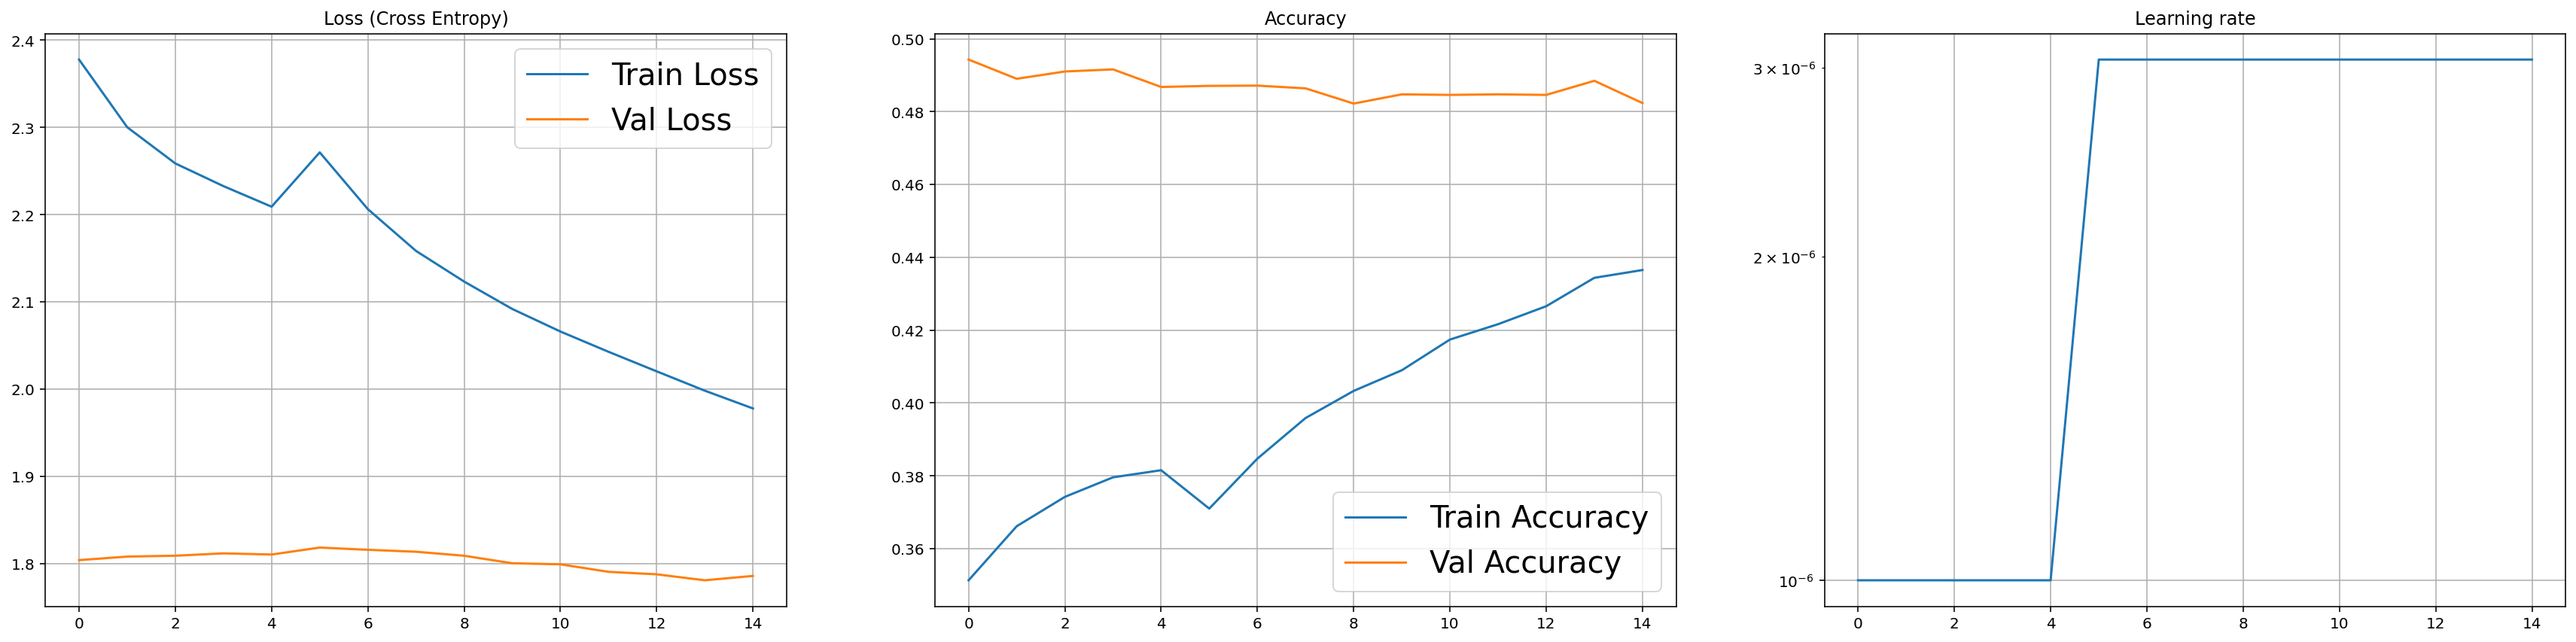

100%|██████████| 210/210 [01:19<00:00,  2.65it/s]


LR: 3.05052908074022e-06
defaultdict(<class 'list'>, {'train_loss': [1.9760801287743133], 'train_accuracy': [0.43730135082630206], 'learning_rate': [3.05052908074022e-06], 'val_loss': [1.7836747918810163], 'val_accuracy': [0.48467261904761905]})


100%|██████████| 210/210 [01:18<00:00,  2.67it/s]


LR: 3.05052908074022e-06
defaultdict(<class 'list'>, {'train_loss': [1.9760801287743133, 1.963915361906263], 'train_accuracy': [0.43730135082630206, 0.4409577373916969], 'learning_rate': [3.05052908074022e-06, 3.05052908074022e-06], 'val_loss': [1.7836747918810163, 1.7768521342958723], 'val_accuracy': [0.48467261904761905, 0.48579545460996176]})


100%|██████████| 210/210 [01:18<00:00,  2.66it/s]


LR: 3.05052908074022e-06
defaultdict(<class 'list'>, {'train_loss': [1.9760801287743133, 1.963915361906263, 1.9400234115848383], 'train_accuracy': [0.43730135082630206, 0.4409577373916969, 0.44663165475955596], 'learning_rate': [3.05052908074022e-06, 3.05052908074022e-06, 3.05052908074022e-06], 'val_loss': [1.7836747918810163, 1.7768521342958723, 1.7762418037369139], 'val_accuracy': [0.48467261904761905, 0.48579545460996176, 0.48518668838909695]})


100%|██████████| 210/210 [01:18<00:00,  2.68it/s]


LR: 3.05052908074022e-06
defaultdict(<class 'list'>, {'train_loss': [1.9760801287743133, 1.963915361906263, 1.9400234115848383, 1.9244832662206157], 'train_accuracy': [0.43730135082630206, 0.4409577373916969, 0.44663165475955596, 0.4482146404568146], 'learning_rate': [3.05052908074022e-06, 3.05052908074022e-06, 3.05052908074022e-06, 3.05052908074022e-06], 'val_loss': [1.7836747918810163, 1.7768521342958723, 1.7762418037369139, 1.7781109963144575], 'val_accuracy': [0.48467261904761905, 0.48579545460996176, 0.48518668838909695, 0.4851190476190476]})


100%|██████████| 210/210 [01:18<00:00,  2.67it/s]


LR: 3.05052908074022e-06
defaultdict(<class 'list'>, {'train_loss': [1.9760801287743133, 1.963915361906263, 1.9400234115848383, 1.9244832662206157, 1.9060804828273241], 'train_accuracy': [0.43730135082630206, 0.4409577373916969, 0.44663165475955596, 0.4482146404568146, 0.4547824791418355], 'learning_rate': [3.05052908074022e-06, 3.05052908074022e-06, 3.05052908074022e-06, 3.05052908074022e-06, 3.05052908074022e-06], 'val_loss': [1.7836747918810163, 1.7768521342958723, 1.7762418037369139, 1.7781109963144575, 1.782100510597229], 'val_accuracy': [0.48467261904761905, 0.48579545460996176, 0.48518668838909695, 0.4851190476190476, 0.4831709958258129]})


100%|██████████| 210/210 [01:19<00:00,  2.65it/s]


LR: 1.1616802896845538e-05
defaultdict(<class 'list'>, {'train_loss': [2.0197829047886207], 'train_accuracy': [0.42458780294592813], 'learning_rate': [1.1616802896845538e-05], 'val_loss': [1.8132099191347757], 'val_accuracy': [0.477516233921051]})


100%|██████████| 210/210 [01:19<00:00,  2.65it/s]


LR: 1.1616802896845538e-05
defaultdict(<class 'list'>, {'train_loss': [2.0197829047886207, 1.9716401417008174], 'train_accuracy': [0.42458780294592813, 0.43525278110043797], 'learning_rate': [1.1616802896845538e-05, 1.1616802896845538e-05], 'val_loss': [1.8132099191347757, 1.8218505490393866], 'val_accuracy': [0.477516233921051, 0.47217261904761904]})


100%|██████████| 210/210 [01:22<00:00,  2.54it/s]


LR: 1.1616802896845538e-05
defaultdict(<class 'list'>, {'train_loss': [2.0197829047886207, 1.9716401417008174, 1.9256460584957638], 'train_accuracy': [0.42458780294592813, 0.43525278110043797, 0.4492699642431466], 'learning_rate': [1.1616802896845538e-05, 1.1616802896845538e-05, 1.1616802896845538e-05], 'val_loss': [1.8132099191347757, 1.8218505490393866, 1.8314347034408933], 'val_accuracy': [0.477516233921051, 0.47217261904761904, 0.4688988095238095]})


100%|██████████| 210/210 [01:22<00:00,  2.55it/s]


LR: 1.1616802896845538e-05
defaultdict(<class 'list'>, {'train_loss': [2.0197829047886207, 1.9716401417008174, 1.9256460584957638, 1.8836703257850584], 'train_accuracy': [0.42458780294592813, 0.43525278110043797, 0.4492699642431466, 0.45740837306317045], 'learning_rate': [1.1616802896845538e-05, 1.1616802896845538e-05, 1.1616802896845538e-05, 1.1616802896845538e-05], 'val_loss': [1.8132099191347757, 1.8218505490393866, 1.8314347034408933, 1.8143884312538874], 'val_accuracy': [0.477516233921051, 0.47217261904761904, 0.4688988095238095, 0.47448593080043794]})


100%|██████████| 210/210 [01:22<00:00,  2.54it/s]


LR: 1.1616802896845538e-05
defaultdict(<class 'list'>, {'train_loss': [2.0197829047886207, 1.9716401417008174, 1.9256460584957638, 1.8836703257850584, 1.843261137054134], 'train_accuracy': [0.42458780294592813, 0.43525278110043797, 0.4492699642431466, 0.45740837306317045, 0.46793057210965433], 'learning_rate': [1.1616802896845538e-05, 1.1616802896845538e-05, 1.1616802896845538e-05, 1.1616802896845538e-05, 1.1616802896845538e-05], 'val_loss': [1.8132099191347757, 1.8218505490393866, 1.8314347034408933, 1.8143884312538874, 1.8357183484804063], 'val_accuracy': [0.477516233921051, 0.47217261904761904, 0.4688988095238095, 0.47448593080043794, 0.47485119047619045]})


100%|██████████| 210/210 [01:22<00:00,  2.54it/s]


LR: 8.010575504357293e-07
defaultdict(<class 'list'>, {'train_loss': [1.9727381567278692], 'train_accuracy': [0.4387974274989675], 'learning_rate': [8.010575504357293e-07], 'val_loss': [1.780581075236911], 'val_accuracy': [0.4861607142857143]})


 82%|████████▏ | 1379/1678 [15:11<03:11,  1.56it/s]

In [ ]:
if MODE==301:
  print('Choose model')
  for name in MODELS_LIST:
    print(name)
  name=input()
  model=model_class_by_name(name)(pretrained=True)
  if os.path.isfile(DATA_FOLDER_PERSISTENT+name+'_warmstart'):
    model.load_state_dict(torch.load(DATA_FOLDER_PERSISTENT+name+'_warmstart'))
    print ('Loaded '+name+' for warm start') 
  model=model.to(device)
  loader_train=torch.utils.data.DataLoader(trainset, batch_size=MODELS_BS_FOR_JOINT[name], num_workers=0,pin_memory=True)
  loader_val=torch.utils.data.DataLoader(valset, batch_size=MODELS_BS_FOR_JOINT[name], num_workers=0,pin_memory=True)
  loader_test=torch.utils.data.DataLoader(testset, batch_size=MODELS_BS_FOR_JOINT[name], num_workers=0,pin_memory=True)
  save_results_list=[]
  lr=1e-6

  train_procedure(model=model,train_loader=loader_train,val_loader=loader_val,model_name=name,
                                                       initial_lr=lr,best_loss=1e6,second_input=False,save_results_list=save_results_list,save_on_permanent=True)
  print(new_eval(model,loader_test,nn.CrossEntropyLoss(),topk=(1,2,3,4,5),second_input=False))
  torch.save(model.state_dict(),DATA_FOLDER_PERSISTENT+name+'_warmstart')
  del model
  torch.cuda.empty_cache()
